<h1>Contents</h1>
- Introduction
- Comparison of Shapley Value to Linear Model Coefficients
- Importing packages and Data Preprocessing
- XGBoost
    - Train model
    - Model performance
- Local Interpretation
    - Generate reasons for predictions by ranking Shapley values
    - Generate reasons for all samples
    - Interactive Plots
        - Force Plots
        - "Cross-over" Contour Plots
- Global Interpretation
    - Feature Importance
    - Partial Dependence Plots (Interactive)
    - Partial Dependence Plots - Interaction Shapley values (Interactive)
    - Raw Feature Values Distribution vs. Shapley Values Distribution (Interactive)
    - Explain the drivers of predicting each class label
    - Scatter Plots - Raw Feature Values Distribution vs. Shapley Values Distribution
- Summary

<h1>Introduction</h1>
<p>The financial industry has yet to seen a full ad potion of Machine Learning models because interpretability of statistical/machine learning models used for decision making is not only desired but also often a regulatory requirement. For example, FCRA(Fair Credit Reporting Act) requires lenders to provide up to 4 decline reasons (adverse action codes) when they decline consumer for credit. These reasons have to be generated from the true underlying models for credit decisions, and the model must be able to isolate specific attributes that led to the model’s negative decision. These regulatory requirements rule out the use of many popular model interpretation tools such as LIME(Local Interpretable Model-Agnostic Explanations) due to the use of surrogate model not the true underlying model, and loss/Gini reduction attribution methods due to not being consistent across samples/models.</p> 
<p>This notebook discusses the newly introduced model interpretation tool - SHAP (SHapley Additive exPlanations) as inspired by Shapley values from cooperative game theory. Shapley values is potentially the the only interpretation tool that satisfies regulatory requirements.</p>

<h1>Comparison of Shapley Value to Linear Model Coefficients</h1>
<p>A (generalized) linear regression model is considered an interpretable model. The contributions by a model attribute(feature) can be simply calculated by multiplying the feature value with the coefficient of that feature, and then minus the expected(averaged) contribution by that feature in the training samples. To explain, here is an excerpt from the book *Interpretable Machine Learning* by Christoph Molnar.</p> 
<p>https://christophm.github.io/interpretable-ml-book/shapley.html</p> 


Here's how a linear model prediction looks like for one data instance:

$$\hat{f}(x_{i\cdot})=\hat{f}(x_{i1},\ldots,x_{ip})=\beta_0+\beta_{1}x_{i1}+\ldots+\beta_{p}x_{ip}$$

where $x_{i\cdot}$ is the instance for which we want to compute the feature effects. Each $x_{ij}$ is a feature value, with $j\in{1,\ldots,p}$. The $\beta_j$ are the weights corresponding to $x_{ij}$.
The feature effect $\phi_{ij}$ of $x_{ij}$ on the prediction $\hat{f}(x_{i\cdot})$ is:

$$\phi_{ij}(\hat{f})=\beta_{j}x_{ij}-E(\beta_{j}X_{j})=\beta_{j}x_{ij}-\beta_{j}E(X_{j})$$

where $E(\beta_jX_{j})$ is the mean effect estimate for feature $X_{j}$. The effect is the difference between the feature contribution to the equation minus the average contribution. 

For a complex model, such as Gradient Boosting Trees or Neural Network, where data relationships can't be simpliy represented by coefficients, Shapley Value from Cooperative Game Theory can be used to calculate $\phi_{ij}$

Please refer to these links for how to calculate/approximate Shapley values:<br>
https://christophm.github.io/interpretable-ml-book/shapley.html#the-shapley-value-in-detail<br>
Lundberg SM, Lee SI (2017), “Consistent feature attribution for tree ensembles”, presented at the 2017 ICML Workshop on Human Interpretability in Machine Learning (WHI 2017), Sydney, NSW, Australia(https://arxiv.org/abs/1706.06060)<br>
Lundberg SM, Lee SI (2017), “A Unified Approach to Interpreting Model Predictions”, Neural Information Processing Systems (NIPS) 2017 (https://arxiv.org/abs/1705.07874)<br>

Also a nice graphic representation of an Interpretable Machine Learning building process:


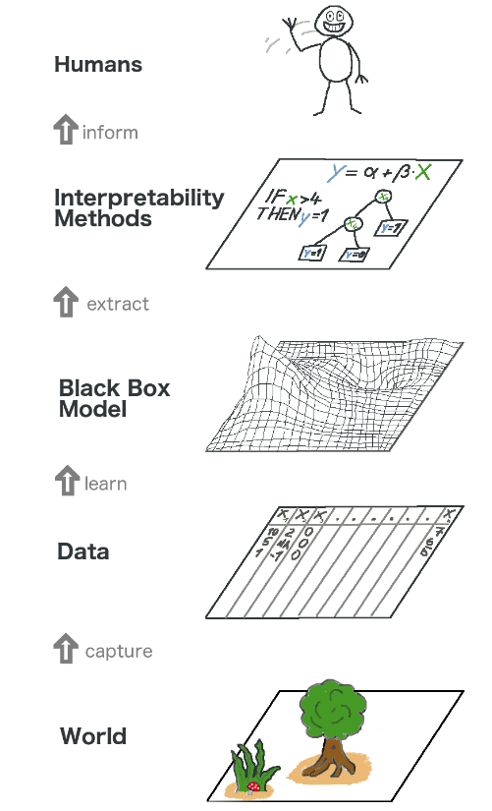

In [1]:
from IPython.display import Image
Image(filename = 'interpret_ML.png')

<h1>Importing packages and Data preprocessing</h1>

In [2]:
import pandas as pd
import numpy as np
import re
np.random.seed(21)
import xgboost as xgb
#import eli5
import matplotlib.pyplot as plt
import pickle
import shap
from ipywidgets import widgets, interactive, interactive_output, fixed, HBox, VBox, Label, interact
from IPython.display import display, HTML
import seaborn as sns
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
import time
from itertools import combinations

%matplotlib inline

/home/carsonyan/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
# Import customized helper functions
import fico_challenge_ultilities as hlp

In [4]:
#==========Data Processing================
dat = pd.read_csv('heloc_dataset_v1.csv')

#Target change to binary
dat['IsBad'] = dat['RiskPerformance']=='Bad'
dat.drop(columns='RiskPerformance', inplace=True)

feat_all = dat.columns
target = 'IsBad'
feat_cat = ['MaxDelq2PublicRecLast12M','MaxDelqEver']
feat_num = [e for e in feat_all if e not in feat_cat+[target]]

#Onehot coding for default values (-7,-8,-9) in numeric columns, replace default values with median 
dat, feat_num_med = hlp.oneHot(dat, feat_num)



In [5]:
#Split data into train, valid and test
dat['rand_num'] = np.random.permutation(np.arange(dat.shape[0]))
cut_1 = int(dat.shape[0]*0.6)
cut_2 = int(dat.shape[0]*0.8)
dat_train = dat.loc[dat['rand_num']<=cut_1,:]

dat_val = dat.loc[(dat['rand_num']>cut_1) & (dat['rand_num']<=cut_2) ,:]
dat_test = dat.loc[dat['rand_num']>cut_2,:]

In [6]:
#Force monotonicity of categorical features at the data input level by transforming them into target means
dat_train, cat_sum_final = hlp.getTargetMean(dat_train, feat_cat, target)


/home/carsonyan/Documents/FICO/fico_challenge_ultilities.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dat[f+'_c'] = dat[f].astype(str)
/home/carsonyan/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [7]:
#Replace categorical fearures in dat_test and dat_val with the target mean summarized from dat_train
dat_val,_ = hlp.getTargetMean(dat_val, feat_cat, target, cat_sum_final=cat_sum_final)
dat_test,_ = hlp.getTargetMean(dat_test, feat_cat, target, cat_sum_final=cat_sum_final)

dat_train.drop(columns=['rand_num'], inplace=True) #feat_cat+
dat_train.to_pickle('dat_train.p')
dat_val.drop(columns=['rand_num'], inplace=True) #feat_cat+
dat_test.drop(columns=['rand_num'], inplace=True) #feat_cat+

In [8]:
dat_train_good = dat_train.loc[dat_train[target]==0,:]
dat_train_good_med = dat_train_good.median()

<h1>XGBoost</h1>

<h2>Train Model</h2>

In [9]:
#========Train model=============

f_names = [e for e in dat_train.columns if e!=target and e not in feat_cat and e not in [c+'_c' for c in feat_cat]]
pickle.dump(f_names, open('f_names','wb'))


train_DM5 = xgb.DMatrix(dat_train[f_names].values, dat_train[target].values, feature_names=f_names)
val_DM5 = xgb.DMatrix(dat_val[f_names].values, dat_val[target].values, feature_names=f_names)
test_DM5 = xgb.DMatrix(dat_test[f_names].values, dat_test[target].values, feature_names=f_names)

params = {
        'eta':0.05,
        'n_estimators':1000,
        'max_depth':4,
        'min_child_weight':10,
        'eval_metric':'auc',
        'sub_sample':0.8,
        'colsample_bytree':0.8,
        'objective':'binary:logistic',
        'seed':21
        }

#        'lambda':30,
#        'gamma':10

monotone_dict = {
 'ExternalRiskEstimate':-1,
 'MSinceOldestTradeOpen':-1,
 'MSinceMostRecentTradeOpen':-1,
 'AverageMInFile':-1,
 'NumSatisfactoryTrades':-1,
 'NumTrades60Ever2DerogPubRec':1,
 'NumTrades90Ever2DerogPubRec':1,
 'PercentTradesNeverDelq':-1,
 'MSinceMostRecentDelq':-1,
 'NumTotalTrades':0,
 'NumTradesOpeninLast12M':1,
 'PercentInstallTrades':0,
 'MSinceMostRecentInqexcl7days':-1,
 'NumInqLast6M':1,
 'NumInqLast6Mexcl7days':1,
 'NetFractionRevolvingBurden':1,
 'NetFractionInstallBurden':1,
 'NumRevolvingTradesWBalance':0,
 'NumInstallTradesWBalance':0,
 'NumBank2NatlTradesWHighUtilization':1,
 'PercentTradesWBalance':0,
 'ExternalRiskEstimate_9':0,
 'MSinceOldestTradeOpen_8':0,
 'MSinceOldestTradeOpen_9':0,
 'MSinceMostRecentTradeOpen_9':0,
 'AverageMInFile_9':0,
 'NumSatisfactoryTrades_9':0,
 'NumTrades60Ever2DerogPubRec_9':0,
 'NumTrades90Ever2DerogPubRec_9':0,
 'PercentTradesNeverDelq_9':0,
 'MSinceMostRecentDelq_7':0,
 'MSinceMostRecentDelq_8':0,
 'MSinceMostRecentDelq_9':0,
 'NumTotalTrades_9':0,
 'NumTradesOpeninLast12M_9':0,
 'PercentInstallTrades_9':0,
 'MSinceMostRecentInqexcl7days_7':0,
 'MSinceMostRecentInqexcl7days_8':0,
 'MSinceMostRecentInqexcl7days_9':0,
 'NumInqLast6M_9':0,
 'NumInqLast6Mexcl7days_9':0,
 'NetFractionRevolvingBurden_8':0,
 'NetFractionRevolvingBurden_9':0,
 'NetFractionInstallBurden_8':0,
 'NetFractionInstallBurden_9':0,
 'NumRevolvingTradesWBalance_8':0,
 'NumRevolvingTradesWBalance_9':0,
 'NumInstallTradesWBalance_8':0,
 'NumInstallTradesWBalance_9':0,
 'NumBank2NatlTradesWHighUtilization_8':0,
 'NumBank2NatlTradesWHighUtilization_9':0,
 'PercentTradesWBalance_8':0,
 'PercentTradesWBalance_9':0,
 'MaxDelq2PublicRecLast12M_tm':1,
 'MaxDelqEver_tm':1}


params['monotone_constraints'] = "("+",".join([str(e) for e in monotone_dict.values()])+")"

pickle.dump(params,open('params.p','wb'))

evalist = [(train_DM5,'train'),(val_DM5,'val')]
evals_result={}



In [10]:
#Change from True to False if you want to train the model
use_trained_model = True
if use_trained_model:
    xgb0 = xgb.Booster()
    xgb0.load_model('xgb0_fico.model')
else:
    tick = time.time()
    xgb0 = xgb.train(params, train_DM5, num_boost_round=params['n_estimators'], evals=evalist, evals_result=evals_result, verbose_eval=True, early_stopping_rounds=50)
    tock = time.time()
    print('Training took {0:.1f} minutes.'.format((tock-tick)/60))

    xgb0.save_model('xgb0_fico.model')


<h2>Model Performance</h2> 
<p>The train, test and validation model performance measured in AUC are close. Because this competition focuses on interpretation rather than predictive power, no tunning is done for the model.</p>

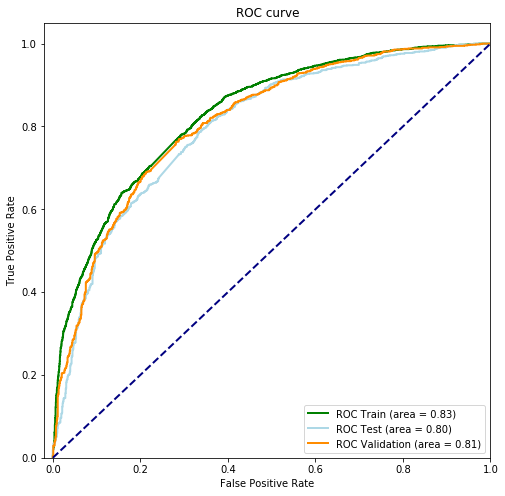

In [11]:
from sklearn.metrics import roc_curve, auc
# Compute micro-average ROC curve and ROC area
fpr_train, tpr_train, _ = roc_curve(dat_train[target], xgb0.predict(train_DM5))
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, _ = roc_curve(dat_test[target], xgb0.predict(test_DM5))
roc_auc_test = auc(fpr_test, tpr_test)
fpr_val, tpr_val, _ = roc_curve(dat_val[target], xgb0.predict(val_DM5))
roc_auc_val = auc(fpr_val, tpr_val)
#xgb.plot_importance(gbm)
#plt.show()
plt.figure(figsize=(8,8))
plt.plot(fpr_train, tpr_train, color='green',
         lw=2, label='ROC Train (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='lightblue',
         lw=2, label='ROC Test (area = %0.2f)' % roc_auc_test)
plt.plot(fpr_val, tpr_val, color='darkorange',
         lw=2, label='ROC Validation (area = %0.2f)' % roc_auc_val)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [12]:
def logistic(x):
    return 1/(1+np.exp(-x))

In [13]:
#Check accuracy
from sklearn.metrics import accuracy_score
print('Accuracy is {0:.3f} if label "bad" for predicted probability greater than 0.5'.format(accuracy_score(dat_train[target], xgb0.predict(train_DM5)>0.5)))

Accuracy is 0.743 if label "bad" for predicted probability greater than 0.5


<p>This model performance is much better than the typical real world credit risk models</p>

<h1>Local Interpretation</h1> 
<h2>Generate reasons for predictions by ranking Shapley values</h2> 

<p>Because Shapley values measure the contributions by feature values to the prediction, the reasons for prediction of a single instance can be generated by ranking the Shapley values. In a classification problem such as the current one, the higher the Shapley value, the bigger effect that the feature value has in predicting the class to be positive (in this case, the "Bads"). </p>
<p>The approval threshold is set to be the average odds. This choice does not change the ranking of Shapley values. In reality, this threshold can be chosen to reflect business strategy.</p>

In [14]:
shap_train = xgb0.predict(xgb.DMatrix(dat_train[f_names].values, feature_names=f_names), pred_contribs=True)
shap_train_bias = shap_train[0,-1]
approval_threshold = shap_train_bias.copy()

In [15]:
#load data dictionary and create a AA reason table
meta = pd.read_excel('heloc_data_dictionary-2.xlsx')
eng = pd.read_excel('aa_english.xlsx')
meta_proc, eng_proc = hlp.processMeta(meta, eng, dat_train_good_med, cat_sum_final)

In [16]:
def getReasonsForSample(new_ins, f_names, feat_cat, feat_num, target, feat_num_med, cat_sum_final, meta_proc, eng_proc, approval_threshold=None, print_reasons=False):
     
    new_ins_p, new_ins_f = hlp.prepObs(new_ins, f_names, feat_cat, feat_num, target, feat_num_med, cat_sum_final)
    shap_pred, shap_bias, shap_pred_raw = hlp.generateReasons(xgb0, f_names, new_ins_p, new_ins_f, meta_proc, eng_proc, print_reasons=print_reasons)
    
    
    if approval_threshold==None:
        approval_threshold=shap_bias 
        
    prediction = 'Bad' if np.sum(shap_pred_raw)>approval_threshold else 'Good'
    
    if np.sum(shap_pred_raw)<approval_threshold: #favorable observation:
        shap_pred = shap_pred.sort_values(by='shap', ascending=True).reset_index(drop=True)
    
    top4_reasons_df = shap_pred.loc[:3,['feature','val','Role']]
    top4_reasons =   shap_pred.loc[:3,'reason'].tolist()
    top4_explanations =   shap_pred.loc[:3,'explanation'].tolist()
    
    return {'reasons_list':[prediction]+top4_reasons+top4_explanations, 'reasons_dataframe':top4_reasons_df,
            'shap':(shap_bias,shap_pred_raw, shap_pred)}
    
        

In [17]:
#Test case
new_ins = pd.read_csv('heloc_dataset_v1.csv').loc[639] #639
#new_ins_p, new_ins_f = hlp.prepObs(new_ins, f_names, feat_cat, feat_num, target, feat_num_med, cat_sum_final)

test = getReasonsForSample(new_ins, f_names, feat_cat, feat_num, target, feat_num_med, cat_sum_final, meta_proc, eng_proc, approval_threshold=None, print_reasons=True)

----------Reasons Analysis--------
The predicted probability of going bad is 0.764
This probability is high.

NumSatisfactoryTrades is too low
Too Few Credit Accounts With On-Time Payments

AverageMInFile is too low
The Average Credit History Is Too Short

NumBank2NatlTradesWHighUtilization_8 is 1.0
No Usable/Valid Trades Or Inquiries For Number Bank/Natl Trades W High Utilization Ratio

NumTotalTrades is 1.0
Not Desirable Number Of Credit Accounts



<h2>Generate reasons for all samples</h2>
<p>Uncomment the codes in the cell below to generate reasons why the prediction for each sample is made. </p>

In [18]:
# tic = time.time()
# samples =  pd.read_csv('heloc_dataset_v1.csv')
# samples['reasons_raw'] = samples.apply(lambda x: getReasonsForSample(x, f_names, feat_cat, feat_num, target, feat_num_med, cat_sum_final, meta_proc, eng_proc), axis=1)['reasons_list']
# samples[['Prediction', 'Reason1','Reason2','Reason3','Reason4','Explanation1','Explanation2','Explanation3','Explanation4']] = pd.DataFrame(samples['reasons_raw'].values.tolist(), index= samples.index)
# samples.drop(columns='reasons_raw', inplace=True)
# samples.to_csv('heloc_dataset_reasons.csv')
# toc = time.time()
# print('It took {0:.1f} minutes'.format((toc-tic)/60))

<h2>Interactive Plots</h2>
<h3>Building widgets and processing data</h3> 

In [19]:
# load JS in order to use some of the plotting functions from the shap
# package in the notebook
shap.initjs()

# create our SHAP explainer
shap_explainer = shap.TreeExplainer(xgb0)
# calculate the shapley values for dat_train
shap_vals = shap_explainer.shap_values(dat_train[f_names]) #, ntree_limit=xgb0.best_iteration

#Check if the values generated are the same from XGBoost
print(np.all(np.isclose(shap_train[:,:-1],shap_vals)))


# plot the explanation for a single prediction
#shap.force_plot(shap_explainer.expected_value, shap_vals[0, :], dat_train.iloc[0, :])

True


In [20]:
all_ins = pd.read_csv('heloc_dataset_v1.csv')
n_rows = all_ins.shape[0]

In [21]:
def prepDataForTestCase(n):
    
    #display('You have chosen the instance with index {}'.format(n))
    new_ins = all_ins.loc[n] #639
    new_ins_p, new_ins_f = hlp.prepObs(new_ins, f_names, feat_cat, feat_num, target, feat_num_med, cat_sum_final)
    output_dict = getReasonsForSample(new_ins, f_names, feat_cat, feat_num, target, feat_num_med, cat_sum_final, meta_proc, eng_proc, approval_threshold=None, print_reasons=False)
    top_4_reasons = output_dict['reasons_dataframe']
    
    deciles_n = 20
    decl_res = []

    for i in range(4):
        if top_4_reasons.loc[i,'feature']=='bias':
            break
        else:
            decl_this = dat_train[top_4_reasons.loc[i,'feature']].quantile([m/(deciles_n) for m in list(range(deciles_n+1))])
            decl_unique_this = np.append(decl_this.values, top_4_reasons.loc[i,'val'])
            decl_unique_this = np.unique(decl_unique_this)
            decl_unique_this = np.sort(decl_unique_this)
            decl_res.append(decl_unique_this)
    
    shap_bias, shap_pred_raw, shap_pred_sort = output_dict['shap']
    pred_orig =  logistic(np.sum(shap_pred_raw)+shap_bias)
    
    if pred_orig >= logistic(approval_threshold):
        c, dc = 'red', 'rejected'
    else:
        c, dc = 'green', 'approved'
    
    #display('This instance will be {0} based on the predicted probability {1:.3f} and the approval threshold.'.format(dc, pred_orig))
        
    return {'instance':new_ins, 'prediction':pred_orig, 'top_reasons':top_4_reasons, 'shap':(shap_bias, shap_pred_raw, shap_pred_sort), 'deciles':decl_res,'graph_elements':(c, dc)}
    

In [22]:
def showGraph(new_ins_index, w0, w1, w2, w3, approval_threshold=None, print_original_reasons=True):
#     print(new_ins_index)
#     print(w0)
#     print(w1)
#     print(w2)
#     print(w3)
#     print(prepDataForTestCase(new_ins_index)['prediction'])
    new_ins = all_ins.loc[new_ins_index]
    top_4_reasons = prepDataForTestCase(new_ins_index)['top_reasons']
    
    new_ins_sim = new_ins.copy()
    for i, w in zip(range(4), [w0, w1, w2, w3]):
        if top_4_reasons.loc[i,'feature'][-2:] in ['_7','_8','_9']: #if default value flag becomes important predictor:
            if w == 0: #if input is 0 - no default value
                if new_ins_sim[top_4_reasons.loc[i,'feature'][:-2]]<0: #check if original feature values is default value
                    #print(new_ins_sim[top_4_reasons.loc[i,'feature'][:-2]])
                    # if default, replace with median of dat
                    new_ins_sim[top_4_reasons.loc[i,'feature'][:-2]]=dat.loc[dat[top_4_reasons.loc[i,'feature'][:-2]]>=0, top_4_reasons.loc[i,'feature'][:-2]].median()
            else:
                new_ins_sim[top_4_reasons.loc[i,'feature'][:-2]]=new_ins[top_4_reasons.loc[i,'feature'][:-2]]
        elif new_ins_sim[top_4_reasons.loc[i,'feature']]>=0: #Not default value in predictor
                new_ins_sim[top_4_reasons.loc[i,'feature']] = w
        else:
            display(HTML('<p>{} has default value and will be replaced by the input value.</br>'.format(top_4_reasons.loc[i,'feature']))) 
            #val = -new_ins_sim[top_4_reasons.loc[i,'feature']]
            new_ins_sim[top_4_reasons.loc[i,'feature']] = w
            #new_ins_sim[top_4_reasons.loc[i,'feature']+'_'+str(val)] = 0
            
            
    #new_ins_sim[top_4_reasons.loc[0,'feature']] = w0
    #new_ins_sim[top_4_reasons.loc[1,'feature']] = w1
    #new_ins_sim[top_4_reasons.loc[2,'feature']] = w2
    #new_ins_sim[top_4_reasons.loc[3,'feature']] = w3
    
    #new_ins_p, new_ins_f = hlp.prepObs(new_ins, f_names, feat_cat, feat_num, target, feat_num_med, cat_sum_final)
    new_ins_sim_p, new_ins_sim_f = hlp.prepObs(new_ins_sim, f_names, feat_cat, feat_num, target, feat_num_med, cat_sum_final)
    #print(new_ins_sim['MaxDelq2PublicRecLast12M'])
    #print(new_ins_sim_f['MaxDelq2PublicRecLast12M_tm'])
    #shap_pred_sim, shap_pred_bias_sim, shap_pred_raw_sim = generateRejectReasons(new_ins_sim, new_ins_sim_f, print_reasons=print_original_reasons)
    #print(type(new_ins_sim))
    #print(type(new_ins_sim_p))
    #print(type(new_ins_sim_f))
    
    shap_pred_sim, shap_pred_bias_sim, shap_pred_raw_sim = hlp.generateReasons(xgb0, f_names, new_ins_sim_p, new_ins_sim_f, meta_proc, eng_proc, print_reasons=print_original_reasons)
    
    #print(np.isclose(shap_pred_raw_sim,shap_pred_raw))
    #print(new_ins_sim)
    pred_sim =  logistic(np.sum(shap_pred_raw_sim)+shap_pred_bias_sim)
    #print(pred_sim)
    
    if pred_sim >= logistic(approval_threshold):
        c, dc = 'red', 'rejected'
    else:
        c, dc = 'green', 'approved'
    display(HTML('<h3>Predicted probability is <font color="{0:s}">{1:.1f}%</font>, this application will be <font color="{0:s}">{2:s}</font> based on the approval threshold.</h3>'.format(c,pred_sim*100, dc))) # logistic(np.sum(shap_pred_raw_sim))))
#     display(HTML('<p>{0:s} original value is {1:.1f}; New value is {2:.1f}</br>'.format(top_4_reasons.loc[0,'feature'], new_ins_f[top_4_reasons.loc[0,'feature']] if top_4_reasons.loc[0,'Role']!='predictor_cat' else new_ins_p[top_4_reasons.loc[0,'feature']].iloc[0],w0)))
#     display(HTML('<p>{0:s} original value is {1:.1f}; New value is {2:.1f}</br>'.format(top_4_reasons.loc[1,'feature'], new_ins_f[top_4_reasons.loc[1,'feature']] if top_4_reasons.loc[1,'Role']!='predictor_cat' else new_ins_p[top_4_reasons.loc[1,'feature']].iloc[0],w1)))
#     display(HTML('<p>{0:s} original value is {1:.1f}; New value is {2:.1f}</br>'.format(top_4_reasons.loc[2,'feature'], new_ins_f[top_4_reasons.loc[2,'feature']] if top_4_reasons.loc[2,'Role']!='predictor_cat' else new_ins_p[top_4_reasons.loc[2,'feature']].iloc[0],w2)))
#     display(HTML('<p>{0:s} original value is {1:.1f}; New value is {2:.1f}</br>'.format(top_4_reasons.loc[3,'feature'], new_ins_f[top_4_reasons.loc[3,'feature']] if top_4_reasons.loc[3,'Role']!='predictor_cat' else new_ins_p[top_4_reasons.loc[3,'feature']].iloc[0],w3)))
#     #display(HTML('<p>Original predicted probability is {0:.3f}; Current predicted probability is {1:.3f}</br>'.format(logistic(np.sum(shap_pred_raw)), logistic(np.sum(shap_pred_raw_sim)))))
    display(shap.force_plot(shap_explainer.expected_value, shap_pred_raw_sim, new_ins_sim[f_names], link="logit"))
    
    

In [23]:
def decisionBoundaryPlot(new_ins_index):
    
    new_ins = all_ins.loc[new_ins_index]
    dict_new = prepDataForTestCase(new_ins_index)
    top_4_reasons = dict_new['top_reasons']
    decision = dict_new['graph_elements'][1]
    decl_res = dict_new['deciles']
    
#     print(new_ins_index)
#     print(top_4_reasons)
#     print(x_feature)
#     print(y_feature)
    
    comb = combinations(list(range(4)), 2)
    comb = [e for e in comb if e[0]!=e[1]]
    plt.figure(figsize=(16,16))
    ct_levels = None
    for i in range(len(comb)):
        plt.subplot(3, 2, i+1)
        d0 = comb[i][0]
        d1 = comb[i][1]
        x = decl_res[d0]
        y = decl_res[d1]
        X, Y = np.meshgrid(x, y)

        #Original datapoint
        x_this = new_ins[top_4_reasons.loc[d0,'feature']]
        y_this = new_ins[top_4_reasons.loc[d1,'feature']]

        #Sythetic data
        new_ins_grid = pd.concat([new_ins]*((X.shape[0])*(X.shape[1])), axis=1).T.reset_index(drop=True)
        new_ins_grid[top_4_reasons.loc[d0,'feature']] = X.reshape((X.shape[0])*(X.shape[1]),-1)
        new_ins_grid[top_4_reasons.loc[d1,'feature']] = Y.reshape((Y.shape[0])*(Y.shape[1]),-1)
        new_ins_grid['IsBad'] = new_ins_grid['RiskPerformance']=='Bad'
        new_ins_grid.drop(columns='RiskPerformance', inplace=True)
        new_ins_grid, _ = hlp.oneHot(new_ins_grid, feat_num)
        new_ins_grid = new_ins_grid.apply(pd.to_numeric)
        new_ins_grid,_ = hlp.getTargetMean(new_ins_grid, feat_cat, target, cat_sum_final=cat_sum_final)
        for f in list(set(f_names)-set(new_ins_grid.columns)):
            new_ins_grid[f]=False

        #Predictions
        pred_grid = xgb0.predict(xgb.DMatrix(new_ins_grid[f_names].values, feature_names=f_names))
        Z = pred_grid.reshape(X.shape[0], X.shape[1])

        
        #ct_line = plt.contour(X, Y, Z, pred_grid.shape[0], colors=('k',))
        if ct_levels is None:
            ct = plt.contourf(X,Y,Z, 20, cmap='RdYlGn_r') #pred_grid.shape[0], summer
            ct_levels = ct.levels 
        else:
            ct = plt.contourf(X,Y,Z, 20, cmap='RdYlGn_r', levels=ct_levels) 
            
        boundary_idx = np.argmax(ct.levels>logistic(approval_threshold))
        #print(boundary_idx)
        ct2 = plt.contour(ct, levels=[ct.levels[boundary_idx]], colors='#00FBFF', linewidths=5)
        cbar = plt.colorbar(ct)
        #cbar.ax.set_ylabel('verbosity coefficient')
        # Add the contour line levels to the colorbar
        #cbar.add_lines(ct2)
        plt.plot([x_this], [y_this], marker='X' if decision=='rejected' else 'o', markersize=8, color="#00FBFF" )
        plt.xlabel(top_4_reasons.loc[d0,'feature'])
        plt.ylabel(top_4_reasons.loc[d1,'feature'])

In [24]:
n=widgets.IntText(value=0,min=0,max=n_rows-1, description='Input index between 0 and {}:'.format(n_rows-1), style = {'description_width': 'initial'})
#w = interactive(prepDataForTestCase, n=n)


In [25]:
dict_0 = prepDataForTestCase(0)    
instance_this = dict_0['instance']
top_4_reasons = dict_0['top_reasons']
shap_bias, shap_pred_raw, shap_pred_sort = dict_0['shap']
decl_res = dict_0['deciles']
c, dc = dict_0['graph_elements']
pred_orig = dict_0['prediction']

In [26]:
wn = widgets.IntText(value=0)

w0 = widgets.SelectionSlider(
    options=decl_res[0],
    value=top_4_reasons.loc[0,'val'] ,
    #description='',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    #style=style,
    readout=True)

w1 = widgets.SelectionSlider(
    options=decl_res[1],
    value=top_4_reasons.loc[1,'val'],
    #description='',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    #style=style,
    readout=True)

w2 = widgets.SelectionSlider(
    options=decl_res[2],
    value=top_4_reasons.loc[2,'val'],
    #description='',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    #style=style,
    readout=True)

w3 = widgets.SelectionSlider(
    options=decl_res[3],
    value=top_4_reasons.loc[3,'val'],
    #description='',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    #style=style,
    readout=True)

w_pred = widgets.IntText(value=0.0)

ui = widgets.VBox([HBox([Label(top_4_reasons.loc[0,'feature']+' (Orig Val: {})'.format(top_4_reasons.loc[0,'val'])),w0]), 
                   HBox([Label(top_4_reasons.loc[1,'feature']+' (Orig Val: {})'.format(top_4_reasons.loc[1,'val'])),w1]),
                   HBox([Label(top_4_reasons.loc[2,'feature']+' (Orig Val: {})'.format(top_4_reasons.loc[2,'val'])),w2]),
                   HBox([Label(top_4_reasons.loc[3,'feature']+' (Orig Val: {})'.format(top_4_reasons.loc[3,'val'])),w3])])

ui2 = widgets.Label(value='Index of the instance is 0')

In [27]:
def updateWidgetsAndVals(change):
    
    dict_new = prepDataForTestCase(change.new)    
    instance_this = dict_new['instance']
    top_4_reasons = dict_new['top_reasons']
    shap_bias, shap_pred_raw, shap_pred_sort = dict_new['shap']
    decl_res = dict_new['deciles']
    c, dc = dict_new['graph_elements']
    pred_orig = dict_new['prediction']
    top_4_reasons_list = top_4_reasons['feature'].tolist()
    
    wn.value = change.new
    w_pred.value = pred_orig
    w0.options=decl_res[0] 
    w1.options=decl_res[1] 
    w2.options=decl_res[2] 
    w3.options=decl_res[3]
    w0.value=top_4_reasons.loc[0,'val']
    w1.value=top_4_reasons.loc[1,'val']
    w2.value=top_4_reasons.loc[2,'val']
    w3.value=top_4_reasons.loc[3,'val']
    ui.children[0].children[0].value = top_4_reasons.loc[0,'feature']+' (Orig Val: {})'.format(top_4_reasons.loc[0,'val'])
    ui.children[1].children[0].value = top_4_reasons.loc[1,'feature']+' (Orig Val: {})'.format(top_4_reasons.loc[1,'val'])
    ui.children[2].children[0].value = top_4_reasons.loc[2,'feature']+' (Orig Val: {})'.format(top_4_reasons.loc[2,'val'])
    ui.children[3].children[0].value = top_4_reasons.loc[3,'feature']+' (Orig Val: {})'.format(top_4_reasons.loc[3,'val'])
    ui2.value = 'Index of the instance is {}'.format(wn.value)
      

<h3>Force Plot</h3>
<p>The Force Plot shows how the feature values are being pushed away the prediction of the instance from the average prediction/base value (0.5172) of the training data. The red bars indicate positive effects (leading to prediction of Bads) from the features and the blue bars indicate the negative effects (leading to prediction of Goods). </p>

How To Use:
- Input a index number to get an instance from the data, the 4 slide bars will refresh accordingly to reflect the top 4 features driving the prediction (allow time to process);  
- Slide the bars to change the feature values of the 4 top features, the prediction will change accordingly;

In [28]:
display(n)
n.observe(updateWidgetsAndVals, names='value')

out = interactive_output(showGraph, {'new_ins_index':wn,'w0': w0, 'w1': w1, 'w2': w2,'w3':w3, 'approval_threshold':fixed(approval_threshold), 'print_original_reasons':fixed(False)})
display(ui, out)

IntText(value=0, description='Input index between 0 and 10458:', style=DescriptionStyle(description_width='ini…

Output()

<h3>"Cross-over" Contour Plots</h3>
<p>A "Cross-over" Contour Plot shows how a "Bad" instance can cross over to become "Good" by changing two of the top 4 features identified above, or vice versa. The decision boundary, as indicated by the cyan line, divides the combinations of feature values that lead to Good (green) or Bad (red) predictions. The solid dot(Good) or x(Bad) indicates the location of the instance.</p>

How To Use:
- Input a index number to get an instance from the data in the Force plot above, the contour plots will refresh accordingly

In [29]:
#out_c = interactive(decisionBoundaryPlot, new_ins_index=wn)
out_c = interactive_output(decisionBoundaryPlot, {'new_ins_index':wn})
display(ui2, out_c)

Label(value='Index of the instance is 1')

Output()

<h1>Global Interpretation</h1> 

<h2>Feature Importance</h2> 

The two biggest advantages of using Shapley values to interpret feature importance:
- The feature importance are summarized from the Shapley values of single instances in the training examples, hence connecting the local interpretability to global interpretability;
- Shapley values are consistant (see https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27), this is very important to the applications in the financial lending industry because of regulatory requirements;

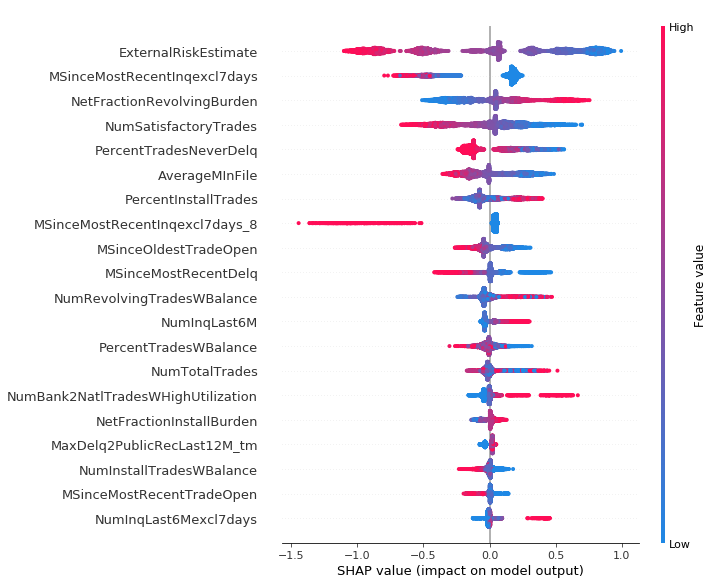

In [32]:
shap.summary_plot(shap_vals, dat_train[f_names])

One thing worth pointing out is the boolean feature MSinceMostRecentInqexcl7days_8, which indicates whether there is a default value in Months Since Most Recent Inq excl 7days:
- If there is a special default value (-8 No Usable/Valid Trades or Inquiries) in Months Since Most Recent Inq excl 7days, the model will predict a lower probability of being "Bad". This may be an unintuitive relationship and one can examine the Shapley values of the raw feature MSinceMostRecentInqexcl7days in both the Good and Bad classes and decide if this relationship makes sense. (According to my observations this actually makes sense)
- If MSinceMostRecentInqexcl7days_8 is True, the Shapley values ranges from -1.5 to -0.5. This is an example that the same feature value will arrive at a different Shapley values in different instances, depending on the values of the other features.

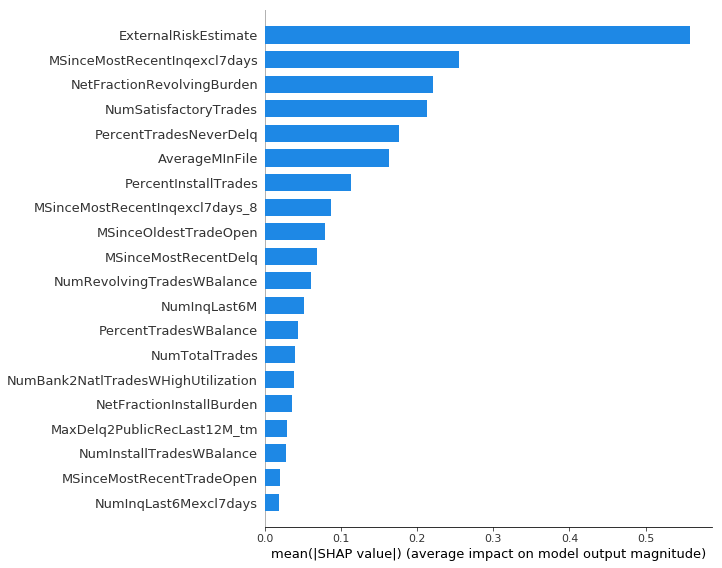

In [33]:
shap.summary_plot(shap_vals, dat_train[f_names], plot_type="bar")

<p>The feature importance plot shows that the ExternalRiskEstimate feature dominates, while MSinceMostRecentInqexcl7days, NetFractionRevolvingBurden, NumSatisfactoryTrades, PercentTradesNeverDelq, AverageMInFile are useful.</p>

In [34]:
shap_df = pd.DataFrame(shap_vals, columns=f_names)
feature_importance = shap_df.abs().mean().sort_values(ascending=False)

<h2>Partial Dependence Plots</h2>
<p>To make a traditional type of PDP, one needs to "probe" the model by feeding inputs in a permutation style and observing the outputs. According to Jerome Friedman, this kind of PDP has to assume the features are relatively uncorrelated. This assumption often breaks down in the applications of Machine Learning models. Independence Conditional Expectation (ICE) plots attempt to solve that problem by disaggregate the PDP.</p>
<p>PDP built with Shapley values, on the other hand, is already disaggregated. And because Shapley values reflect the accurate and consistent contributions by features, it does not suffer the problem a traditional PDP does. </p>
<p>The PDP shown below also allow users to observe interactions, by color coding the scale of a second feature. </p>

In [35]:
w_main =  widgets.Dropdown(
    options=list(feature_importance.index),
    value='ExternalRiskEstimate',
    description='Main Feature:',
    style = {'description_width': 'initial'},
    disabled=False)
    
w_interact =  widgets.Dropdown(
    options=list(feature_importance.index)+['auto'],
    value='auto',
    description='Interact Feature:',
    style = {'description_width': 'initial'},
    disabled=False)

In [36]:
def plot_dependence(main,interact,shap_vals,data):
    if main!=interact:
        shap.dependence_plot(main, shap_vals, data, interaction_index = interact,alpha=.7, show=False)
    else:
        shap.dependence_plot(main, shap_vals, data,alpha=.7, interaction_index = None, show=False)
    plt.gcf().set_size_inches(10, 8)
    plt.show()

In [37]:
out_pd = interactive(plot_dependence, main=w_main,interact=w_interact,shap_vals=fixed(shap_vals),data=fixed(dat_train[f_names]))
display(out_pd)

interactive(children=(Dropdown(description='Main Feature:', options=('ExternalRiskEstimate', 'MSinceMostRecent…

Interaction effect observed:
- When ExternalRiskEstimate is low, a high NetFractionRevolvingBurden will lead to an even higher probability of being bad;
- When NetFractionRevolvingBurden is between 30 and 75, a high NumSatisfactoryTrades will lead to an even higher probability of being bad; whereas when NetFractionRevolvingBurden is below 30, a high NumSatisfactoryTrades will result in a lower probability of being bad;
- When PercentTradesNeverDelq is lower than 90, a high NetFractionRevolvingBurden will result in a lower probability of being bad;
- When AverageMInFile is lower than 75, a high NetFractionRevolvingBurden will lead to a lower probability of being bad;

<h2>Partial Dependence Plots - Interaction Shapley values</h2>
<p>The above observations can be validated by looking at the Interaction Shapley values directly</p>

In [36]:
shap_interaction_values = shap.TreeExplainer(xgb0).shap_interaction_values(dat_train[f_names])

In [37]:
def plot_interaction_dependence(main,interact,shap_interaction_values,data):
    interact = main if interact=='auto' else interact
    shap.dependence_plot((main, interact), shap_interaction_values, data,alpha=.7, show=False)
    plt.gcf().set_size_inches(10, 8)
    plt.show()



In [38]:
out_pd_int = interactive(plot_interaction_dependence, main=w_main,interact=w_interact,shap_interaction_values=fixed(shap_interaction_values),data=fixed(dat_train[f_names]))
display(out_pd_int)

interactive(children=(Dropdown(description='Main Feature:', options=('ExternalRiskEstimate', 'MSinceMostRecent…

<h2>Raw Feature Values Distribution vs. Shapley Values Distribution</h2>
<p>The distribution of raw feature values against the two classes and the distribution of Shapley values are plotted together to understand what cause the difference in the prediction of each class.</p>

In [39]:
pred_train = xgb0.predict(train_DM5)
pred_label_train = pred_train>logistic(approval_threshold)

In [40]:
shap_vals_true = shap_vals[pred_label_train,:]
shap_vals_false = shap_vals[~pred_label_train,:]
dat_train_true = dat_train.loc[pred_label_train,f_names].values
dat_train_false = dat_train.loc[~pred_label_train,f_names].values


In [41]:
def plot_dist(feature):
    #print(f)
    idx_f = f_names.index(feature)
    fig = plt.figure(figsize=(14,6))
    ax1 = fig.add_subplot(1, 2, 1)
    sns.distplot(dat_train_false[:,idx_f].astype(np.float),kde=False, ax=ax1, label='Predicted_Good')
    sns.distplot(dat_train_true[:,idx_f].astype(np.float),kde=False, ax=ax1, label='Predicted_Bad')
    ax1.set_title('Raw values')
    ax1.legend()

    ax2 = fig.add_subplot(1, 2, 2)
    sns.distplot(shap_vals_false[:,idx_f],kde=False, ax=ax2, label='Predicted_Good')
    sns.distplot(shap_vals_true[:,idx_f],kde=False, ax=ax2, label='Predicted_Bad')
    ax2.set_title('Shapley values')
    ax2.legend()

    #plt.gcf().set_size_inches(10, 8)
    fig.suptitle(feature)
    plt.show()

In [42]:
f_options =  widgets.Dropdown(
    options=list(feature_importance.index),
    value='ExternalRiskEstimate',
    description='Feature:',
    style = {'description_width': 'initial'},
    disabled=False)

In [43]:
out_dist = interactive(plot_dist, feature=f_options)
display(out_dist)

interactive(children=(Dropdown(description='Feature:', options=('ExternalRiskEstimate', 'MSinceMostRecentInqex…

<p>The distribution of Shapley values tends to be more "separated" than the distribution of raw feature values. This could be a result of Shapley values' ability to isolate feature effects.</p>

<h2>Explain the drivers of predicting each class label</h2>
<p>This section examine the top 5 features in predicting each class (as indicated by their Shapley values) and their typical raw feature values ranges.</p>

In [44]:
def featureSummaryRankByShap(data, feature_names, shap_values, sort_ascending=False):
    shap_values_df = pd.DataFrame(shap_values, columns=feature_names)
    shap_values_df_mean = shap_values_df.mean()
    sum_df = pd.concat([shap_values_df_mean, data.mean()], axis=1)
    sum_df.columns = ['shap_val_mean','orig_val_mean']
    sum_df = pd.concat([sum_df,data.quantile([.1, .25, .5, .75, .9]).T], axis=1)
    sum_df.sort_values(by='shap_val_mean',inplace=True, ascending=sort_ascending)
    
    return sum_df



In [45]:
summary_1 = featureSummaryRankByShap(dat_train.loc[pred_label_train,f_names],f_names,shap_vals_true)
summary_0 = featureSummaryRankByShap(dat_train.loc[~pred_label_train,f_names],f_names,shap_vals_false,sort_ascending=True)

In [46]:
def explainClass(summary, data_dictionary=eng, top=5, use_English=True):
    label = 'Bad' if summary.iloc[0,0]>0 else 'Good'
    reasons = []
    for i in range(top):
        f_this = summary.index[i]
        eng_this = data_dictionary.loc[data_dictionary['feature']==f_this,'feature_desc'].iat[0]
        reasons.append(eng_this+' has 80% of values range from {0:.1f} to {1:.1f}'.format(summary.loc[f_this,0.1], summary.loc[f_this,0.9]))
    print('*** Class "{}" has these characteristics: ***\n'.format(label)+';\n'.join(reasons))
    return reasons

In [47]:
_ = explainClass(summary_0)

*** Class "Good" has these characteristics: ***
Consolidated version of risk markers has 80% of values range from 71.0 to 88.0;
Net Fraction Revolving Burden has 80% of values range from 1.0 to 47.0;
Percent Trades Never Delinquent has 80% of values range from 92.0 to 100.0;
Months Since Most Recent Inq excl 7days has 80% of values range from 0.0 to 10.0;
Average Months in File has 80% of values range from 57.0 to 132.0


In [48]:
_ = explainClass(summary_1)

*** Class "Bad" has these characteristics: ***
Consolidated version of risk markers has 80% of values range from 57.0 to 73.0;
Net Fraction Revolving Burden has 80% of values range from 12.0 to 86.0;
Percent Trades Never Delinquent has 80% of values range from 71.0 to 100.0;
Months Since Most Recent Inq excl 7days has 80% of values range from 0.0 to 2.0;
Average Months in File has 80% of values range from 31.0 to 103.0


Both classes have the same top 5 features

<h2>Scatter Plots - Raw Feature Values Distribution vs. Shapley Values Distribution</h2>
<p>The pairwise scatter plots shows what feature and two features combinations that are useful in separating the Goods from the Bads.</p>

In [49]:
top5 = summary_1.index[:5]
dat_train_with_pred = dat_train.copy()
dat_train_with_pred['pred_label'] = 'Good'
dat_train_with_pred.loc[pred_label_train,'pred_label']='Bad'


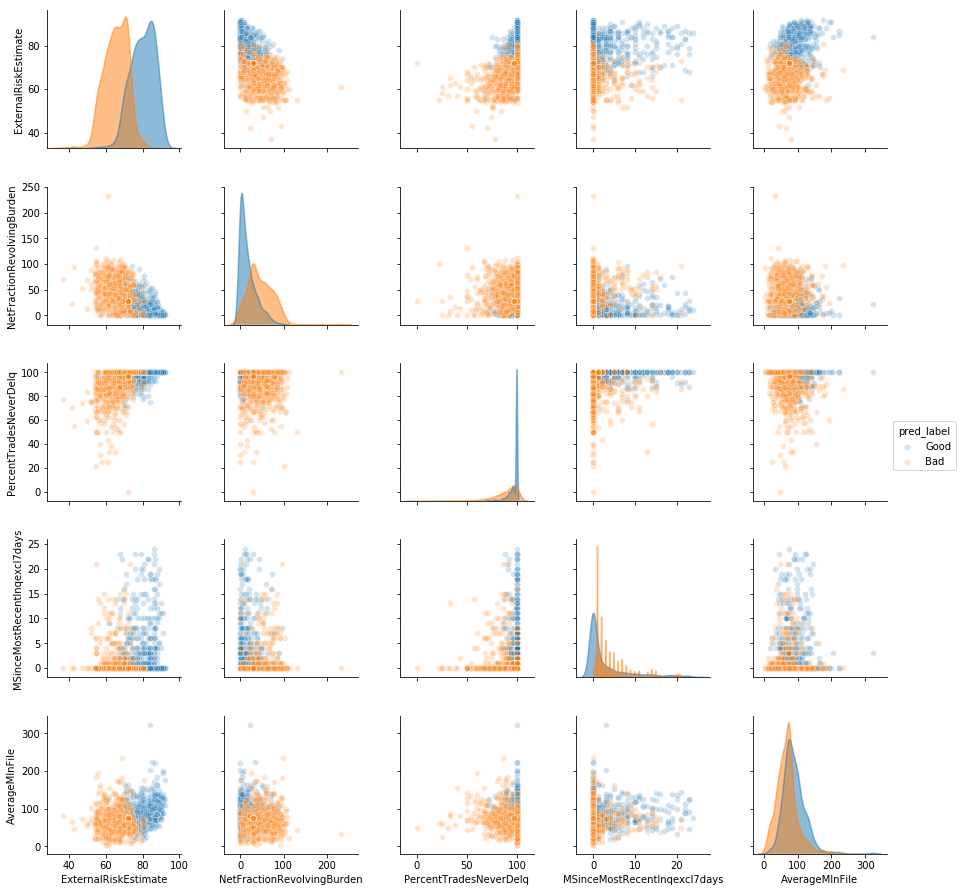

In [50]:
sns.pairplot(dat_train_with_pred[list(top5)+['pred_label']].sample(frac=0.2), hue="pred_label", diag_kind="kde", plot_kws=dict(alpha= 0.2), diag_kws=dict(shade=True,alpha= 0.5), hue_order=['Good','Bad'])

In [51]:
shap_train_df = pd.DataFrame(shap_vals, columns=f_names)
shap_train_df['pred_label'] = 'Good'
shap_train_df.loc[pred_label_train,'pred_label']='Bad'

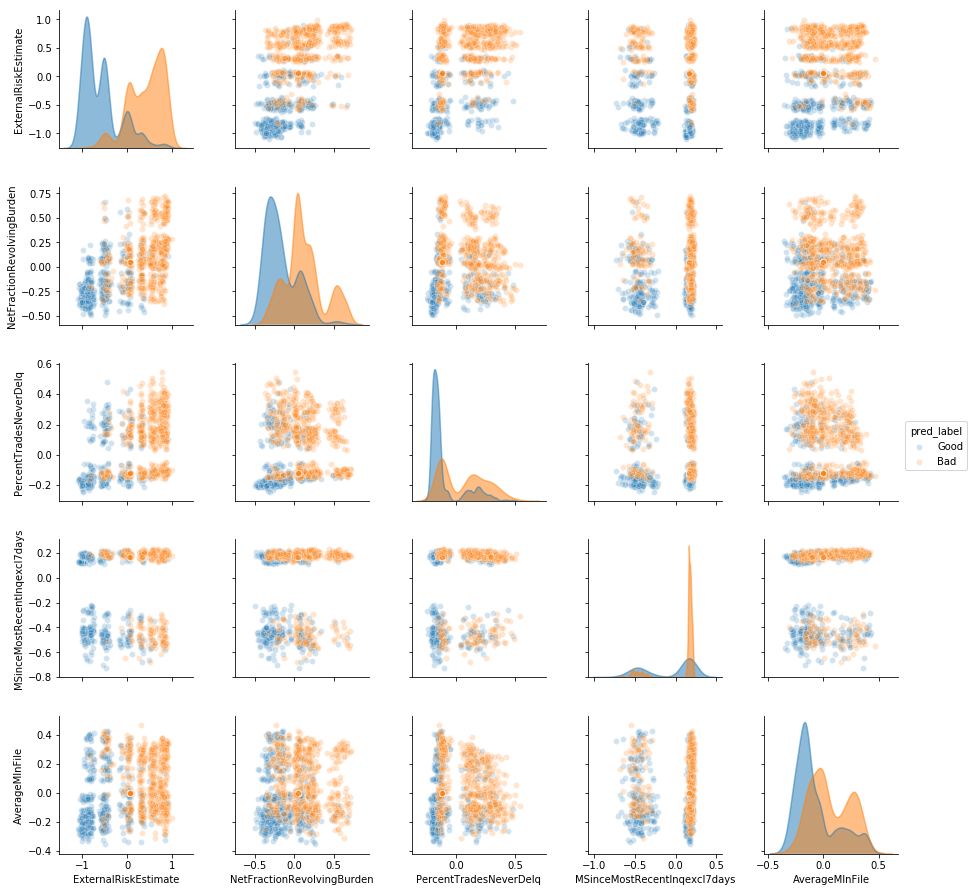

In [52]:
sns.pairplot(shap_train_df[list(top5)+['pred_label']].sample(frac=0.2), hue="pred_label", diag_kind="kde", plot_kws=dict(alpha= 0.2), diag_kws=dict(shade=True,alpha= 0.5), hue_order=['Good','Bad'])

<p>Again, the distribution of Shapley values tends to be more "separated" than the distribution of raw feature values. Some of combinations such as ExternalRiskEstimate+NetFractionRevolvingBurden and MSinceMostRecentInqexcl7days+NumSatisfactoryTrades are useful in separating the Goods from the Bads. </p>

<h1>Summary</h1>

<p>This notebook builds a XGBoost model and uses Shapley values to interpret the model both locally and globally. Shapley values fairly distribute the prediction contributions to each of the feature values, and can be summed in a linear way that allows human to comprehend. The global interpretability built by summarizing Shapley values from the ground up, provides transparency and consistency into how the model predict each of the two classes.</p>

Future works:
- Streamline codes to run the analysis more efficiently;
- Although Shapley values should work similarly with other model algorithms, discuss Shapley values from various types of algorithms will be beneficial;